In [1]:
import argparse
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

/Users/aaronlow/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
warnings.filterwarnings("ignore")
PALETTE = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
sns.set_theme(style="whitegrid", palette=PALETTE)

# Austin Data

In [3]:
austin_df = pd.read_csv("austin_data.csv")
austin_df["Start_Time"] = pd.to_datetime(austin_df["Start_Time"], errors="coerce")
austin_df["End_Time"]   = pd.to_datetime(austin_df["End_Time"],   errors="coerce")
austin_df["Hour"] = austin_df["Start_Time"].dt.hour
austin_df["DayOfWeek"] = austin_df["Start_Time"].dt.day_name()
austin_df["Month"] = austin_df["Start_Time"].dt.month
austin_df["MonthName"] = austin_df["Start_Time"].dt.month_name()
austin_df["Year"] = austin_df["Start_Time"].dt.year
austin_df["Duration_hr"] = (austin_df["End_Time"] - austin_df["Start_Time"]).dt.total_seconds() / 3600
season_map = {12:"Winter",1:"Winter",2:"Winter",
                3:"Spring",4:"Spring",5:"Spring",
                6:"Summer",7:"Summer",8:"Summer",
                9:"Fall",10:"Fall",11:"Fall"}
austin_df["Season"] = austin_df["Month"].map(season_map)
print(f"Loaded {len(austin_df):,} records  |  columns: {austin_df.shape[1]}")

Loaded 97,359 records  |  columns: 53


## Severity Analysis

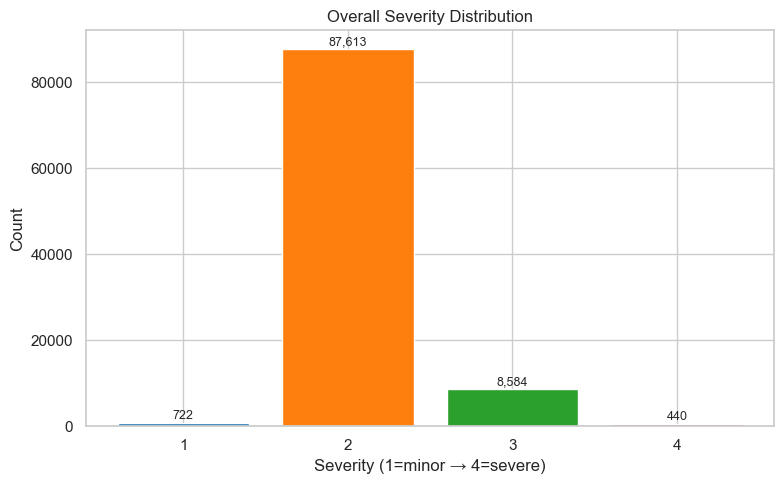

In [4]:
# 1a  Overall severity distribution
fig, ax = plt.subplots(figsize=(8, 5))
counts = austin_df["Severity"].value_counts().sort_index()
bars = ax.bar(counts.index.astype(str), counts.values, color=PALETTE)
ax.set_title("Overall Severity Distribution")
ax.set_xlabel("Severity (1=minor → 4=severe)")
ax.set_ylabel("Count")
for bar, v in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f"{v:,}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
#plt.savefig("1a_severity_distribution.png", dpi=150, bbox_inches="tight")
#print("Saved: 1a_severity_distribution.png")
plt.show()

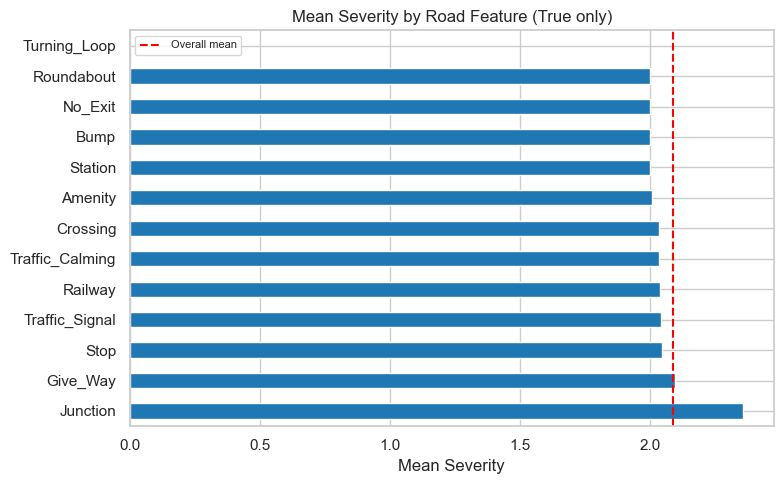

In [5]:
# 1b  Average severity by road feature
bool_cols = ["Amenity","Bump","Crossing","Give_Way","Junction",
            "No_Exit","Railway","Roundabout","Station","Stop",
                "Traffic_Calming","Traffic_Signal","Turning_Loop"]
bool_cols = [c for c in bool_cols if c in austin_df.columns]
sev_by_feat = {c: austin_df[austin_df[c]==True]["Severity"].mean() for c in bool_cols}
feat_df = pd.Series(sev_by_feat).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8, 5))
feat_df.plot(kind="barh", ax=ax, color="#1f77b4")
ax.axvline(austin_df["Severity"].mean(), color="red", linestyle="--", label="Overall mean")
ax.set_title("Mean Severity by Road Feature (True only)")
ax.set_xlabel("Mean Severity")
ax.legend(fontsize=8)
plt.tight_layout()
#plt.savefig("1b_severity_by_road_feature.png", dpi=150, bbox_inches="tight")
#print("Saved: 1b_severity_by_road_feature.png")
plt.show()

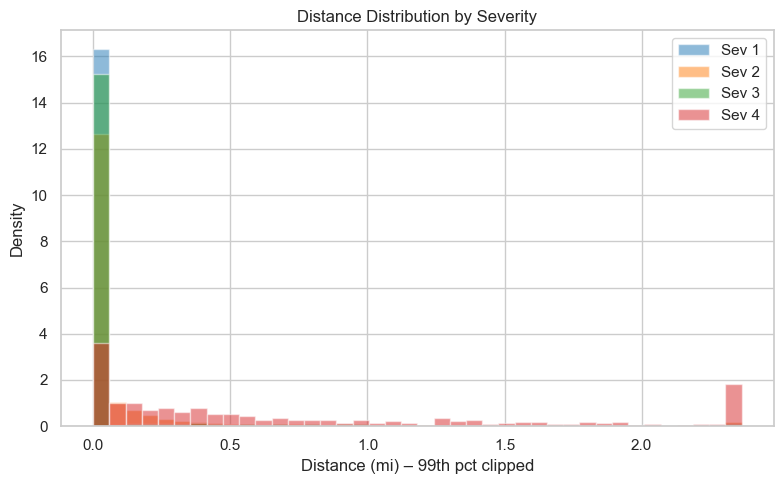

In [6]:
# 1c  Severity vs Distance
fig, ax = plt.subplots(figsize=(8, 5))
dist_clip = austin_df["Distance(mi)"].clip(upper=austin_df["Distance(mi)"].quantile(0.99))
for sev, grp in austin_df.groupby("Severity"):
    ax.hist(dist_clip[grp.index], bins=40, alpha=0.5,
            label=f"Sev {sev}", density=True)
ax.set_title("Distance Distribution by Severity")
ax.set_xlabel("Distance (mi) – 99th pct clipped")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
#plt.savefig("1c_distance_by_severity.png", dpi=150, bbox_inches="tight")
#print("Saved: 1c_distance_by_severity.png")
plt.show()

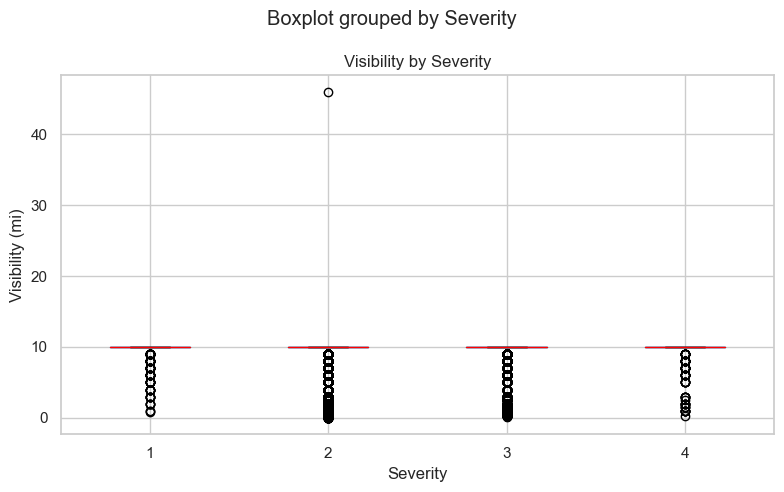

In [7]:
# 1d  Severity vs Visibility
fig, ax = plt.subplots(figsize=(8, 5))
austin_df.boxplot(column="Visibility(mi)", by="Severity", ax=ax,
            boxprops=dict(color="#1f77b4"), medianprops=dict(color="red"))
ax.set_title("Visibility by Severity")
ax.set_xlabel("Severity")
ax.set_ylabel("Visibility (mi)")
plt.sca(ax); plt.title("Visibility by Severity")
plt.tight_layout()
#plt.savefig("1d_visibility_by_severity.png", dpi=150, bbox_inches="tight")
#print("Saved: 1d_visibility_by_severity.png")
plt.show()

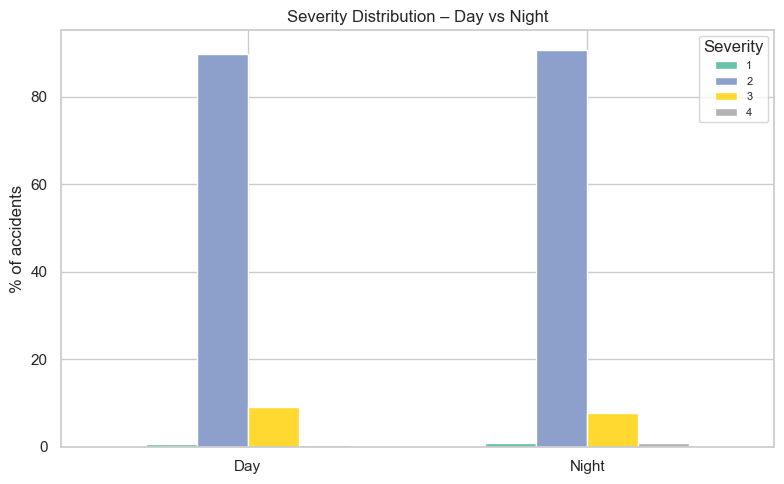

In [8]:
# 1e  Severity by day/night
if "Sunrise_Sunset" in austin_df.columns:
    fig, ax = plt.subplots(figsize=(8, 5))
    ss_sev = austin_df.groupby("Sunrise_Sunset")["Severity"].value_counts(normalize=True).mul(100).unstack()
    ss_sev.plot(kind="bar", ax=ax, colormap="Set2", width=0.6)
    ax.set_title("Severity Distribution – Day vs Night")
    ax.set_xlabel("")
    ax.set_ylabel("% of accidents")
    ax.tick_params(axis="x", rotation=0)
    ax.legend(title="Severity", fontsize=8)
    plt.tight_layout()
    #plt.savefig("1e_severity_day_night.png", dpi=150, bbox_inches="tight")
    #print("Saved: 1e_severity_day_night.png")
    plt.show()

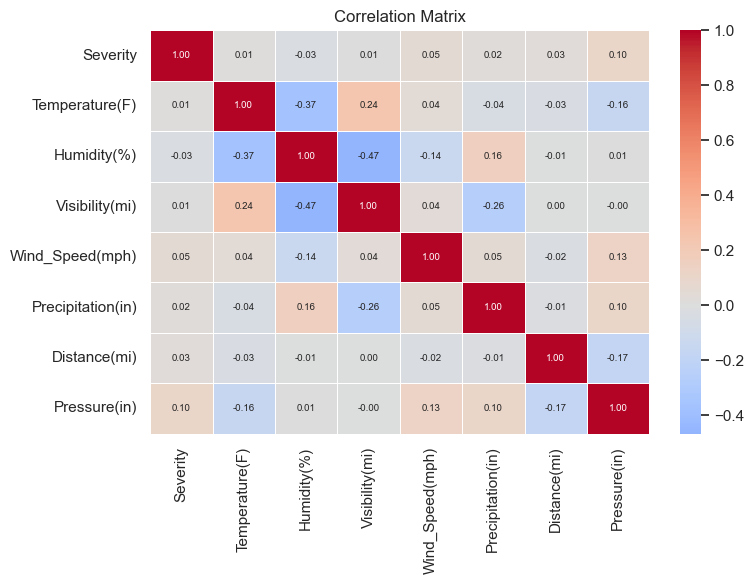

In [9]:
# 1f  Correlation heatmap (numeric)
fig, ax = plt.subplots(figsize=(8, 6))
num_cols = ["Severity","Temperature(F)","Humidity(%)","Visibility(mi)",
            "Wind_Speed(mph)","Precipitation(in)","Distance(mi)","Pressure(in)"]
num_cols = [c for c in num_cols if c in austin_df.columns]
corr = austin_df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", ax=ax,
            cmap="coolwarm", center=0, linewidths=0.5, annot_kws={"size":7})
ax.set_title("Correlation Matrix")
plt.tight_layout()
#plt.savefig("1f_correlation_matrix.png", dpi=150, bbox_inches="tight")
#print("Saved: 1f_correlation_matrix.png")
plt.show()

# Time-Based Analysis

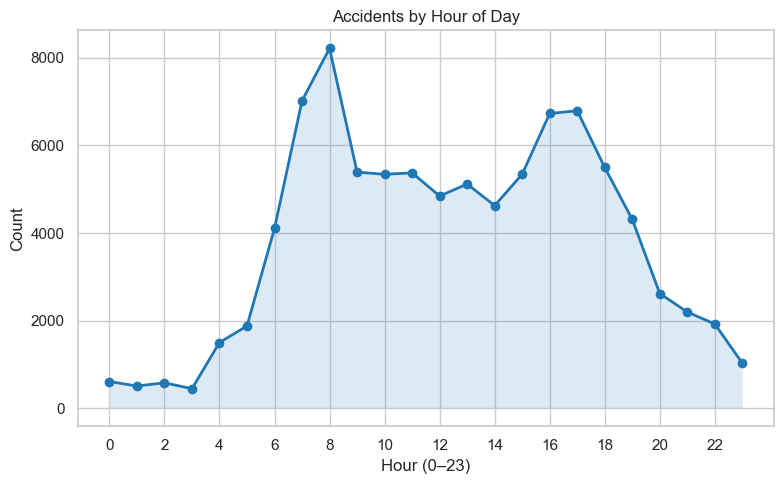

In [10]:
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
season_order = ["Spring","Summer","Fall","Winter"]

# 2a  Accidents by hour
fig, ax = plt.subplots(figsize=(8, 5))
hour_counts = austin_df.groupby("Hour").size()
ax.plot(hour_counts.index, hour_counts.values, marker="o", color="#1f77b4", linewidth=2)
ax.fill_between(hour_counts.index, hour_counts.values, alpha=0.15)
ax.set_title("Accidents by Hour of Day")
ax.set_xlabel("Hour (0–23)")
ax.set_ylabel("Count")
ax.set_xticks(range(0, 24, 2))
plt.tight_layout()
#plt.savefig("2a_accidents_by_hour.png", dpi=150, bbox_inches="tight")
#print("Saved: 2a_accidents_by_hour.png")
plt.show()

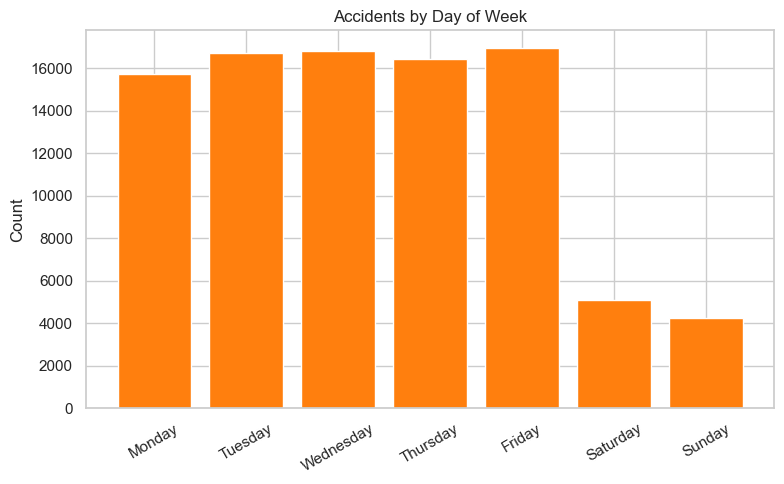

In [11]:
# 2b  Accidents by day of week
fig, ax = plt.subplots(figsize=(8, 5))
dow = austin_df["DayOfWeek"].value_counts().reindex(day_order)
ax.bar(dow.index, dow.values, color="#ff7f0e")
ax.set_title("Accidents by Day of Week")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=30)
ax.set_ylabel("Count")
plt.tight_layout()
#plt.savefig("2b_accidents_by_dow.png", dpi=150, bbox_inches="tight")
#print("Saved: 2b_accidents_by_dow.png")
plt.show()

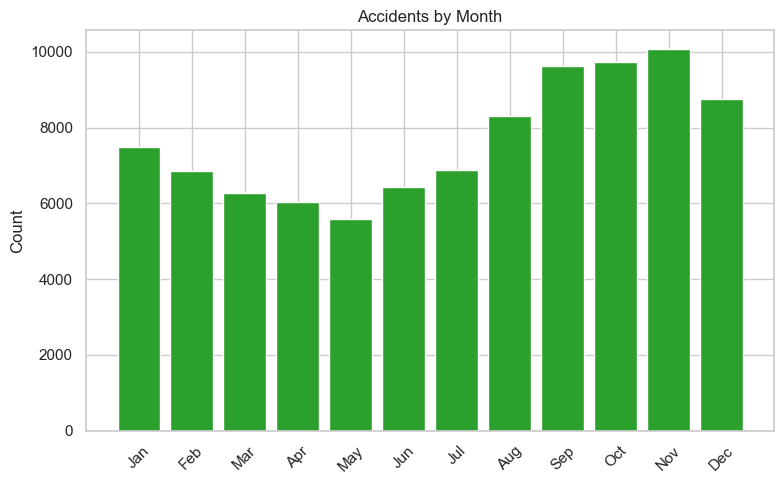

In [12]:
# 2c  Accidents by month
fig, ax = plt.subplots(figsize=(8, 5))
mon = austin_df.groupby("Month").size().reindex(range(1, 13), fill_value=0)
mon.index = ["Jan","Feb","Mar","Apr","May","Jun",
             "Jul","Aug","Sep","Oct","Nov","Dec"]
ax.bar(mon.index, mon.values, color="#2ca02c")
ax.set_title("Accidents by Month")
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel("Count")
plt.tight_layout()
#plt.savefig("2c_accidents_by_month.png", dpi=150, bbox_inches="tight")
#print("Saved: 2c_accidents_by_month.png")
plt.show()

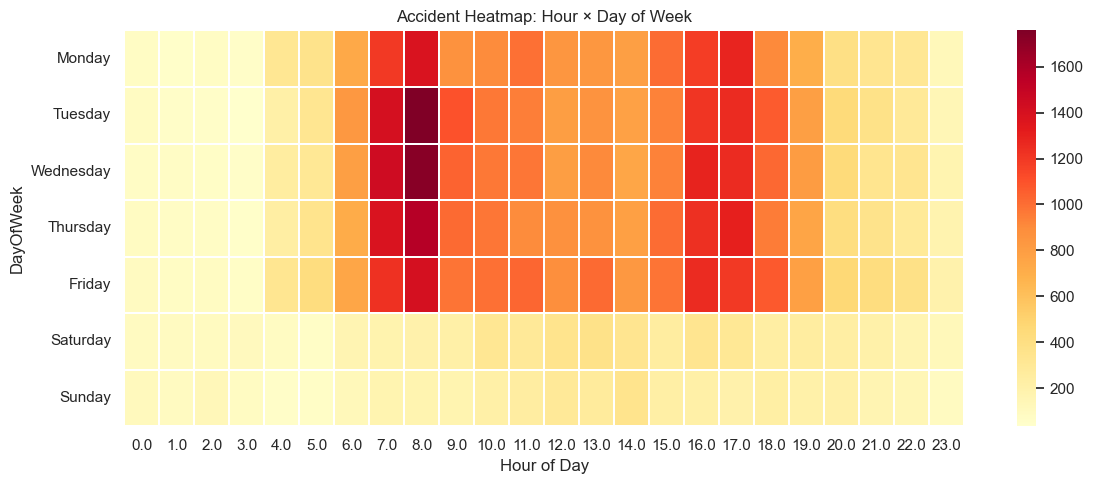

In [13]:
# 2d  Heatmap: hour × day-of-week
fig, ax = plt.subplots(figsize=(12, 5))
pivot = austin_df.pivot_table(index="DayOfWeek", columns="Hour",
                       values="ID", aggfunc="count").reindex(day_order)
sns.heatmap(pivot, ax=ax, cmap="YlOrRd", linewidths=0.2)
ax.set_title("Accident Heatmap: Hour × Day of Week")
ax.set_xlabel("Hour of Day")
plt.tight_layout()
#plt.savefig("2d_heatmap_hour_dow.png", dpi=150, bbox_inches="tight")
#print("Saved: 2d_heatmap_hour_dow.png")
plt.show()

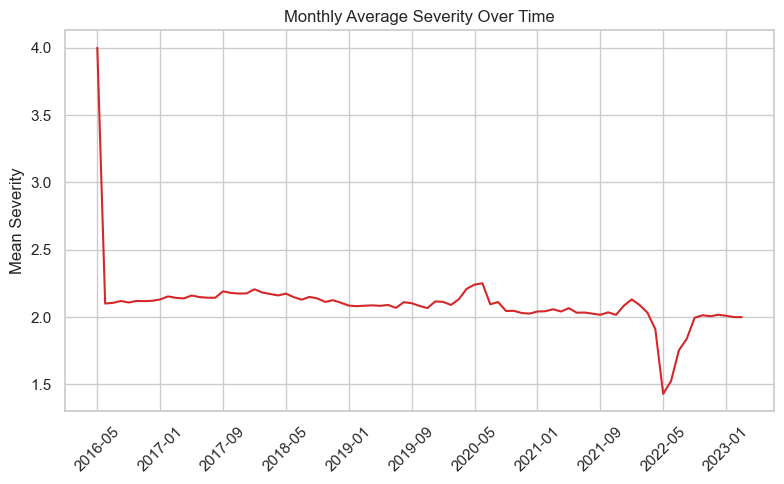

In [14]:
# 2e  Severity over time (monthly avg)
fig, ax = plt.subplots(figsize=(8, 5))
monthly_sev = austin_df.groupby(austin_df["Start_Time"].dt.to_period("M"))["Severity"].mean()
monthly_sev.index = monthly_sev.index.astype(str)
ax.plot(monthly_sev.index, monthly_sev.values, color="#d62728", linewidth=1.5)
tick_step = max(1, len(monthly_sev) // 10)
ax.set_xticks(monthly_sev.index[::tick_step])
ax.tick_params(axis="x", rotation=45)
ax.set_title("Monthly Average Severity Over Time")
ax.set_ylabel("Mean Severity")
plt.tight_layout()
#plt.savefig("2e_monthly_severity.png", dpi=150, bbox_inches="tight")
#print("Saved: 2e_monthly_severity.png")
plt.show()

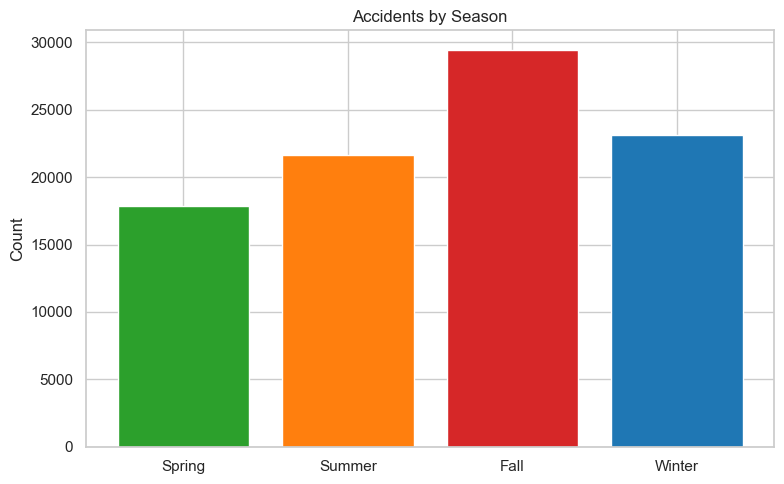

In [15]:
# 2f  Accidents by season
fig, ax = plt.subplots(figsize=(8, 5))
season_counts = austin_df["Season"].value_counts().reindex(season_order)
ax.bar(season_counts.index, season_counts.values,
       color=["#2ca02c","#ff7f0e","#d62728","#1f77b4"])
ax.set_title("Accidents by Season")
ax.set_ylabel("Count")
plt.tight_layout()
#plt.savefig("2f_accidents_by_season.png", dpi=150, bbox_inches="tight")
#print("Saved: 2f_accidents_by_season.png")
plt.show()

# Weather Based Analysis

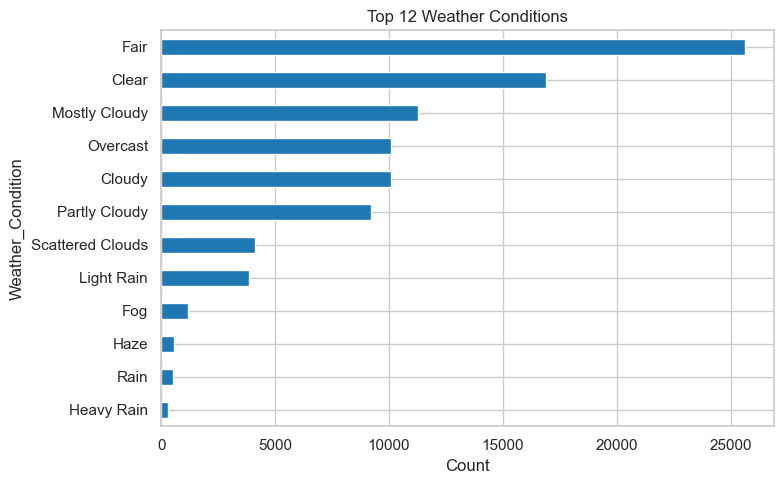

In [16]:
# 3a  Top weather conditions
fig, ax = plt.subplots(figsize=(8, 5))
if "Weather_Condition" in austin_df.columns:
    wc = austin_df["Weather_Condition"].value_counts().head(12)
    wc.sort_values().plot(kind="barh", ax=ax, color="#1f77b4")
    ax.set_title("Top 12 Weather Conditions")
    ax.set_xlabel("Count")
plt.tight_layout()
# plt.savefig("3a_top_weather_conditions.png", dpi=150, bbox_inches="tight")
# print("Saved: 3a_top_weather_conditions.png")
plt.show()

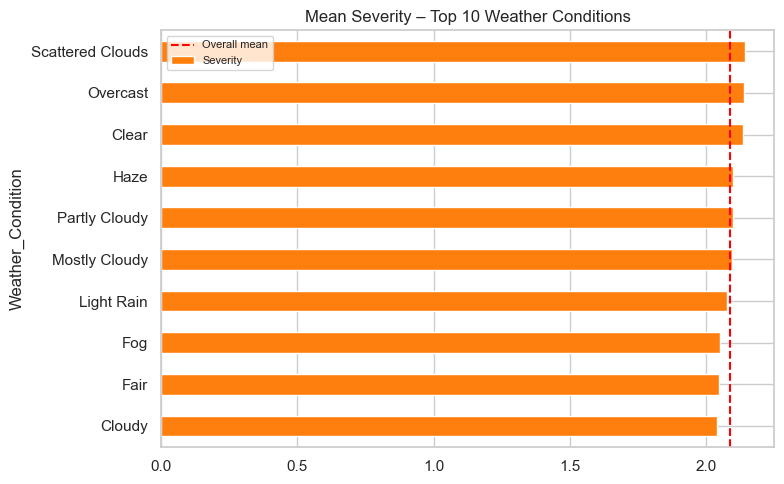

In [17]:
# 3b  Mean severity by top weather condition
fig, ax = plt.subplots(figsize=(8, 5))
if "Weather_Condition" in austin_df.columns:
    top_wc = austin_df["Weather_Condition"].value_counts().head(10).index
    sev_wc = austin_df[austin_df["Weather_Condition"].isin(top_wc)]\
               .groupby("Weather_Condition")["Severity"].mean().sort_values()
    sev_wc.plot(kind="barh", ax=ax, color="#ff7f0e")
    ax.axvline(austin_df["Severity"].mean(), color="red", linestyle="--", label="Overall mean")
    ax.set_title("Mean Severity – Top 10 Weather Conditions")
    ax.legend(fontsize=8)
plt.tight_layout()
# plt.savefig("3b_severity_by_weather.png", dpi=150, bbox_inches="tight")
# print("Saved: 3b_severity_by_weather.png")
plt.show()

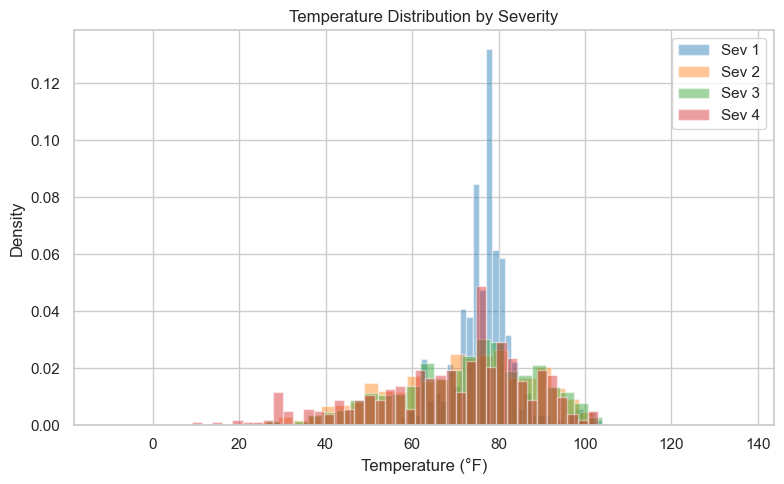

In [18]:
# 3c  Temperature histogram by severity
fig, ax = plt.subplots(figsize=(8, 5))
for sev, grp in austin_df.groupby("Severity"):
    grp["Temperature(F)"].dropna().hist(ax=ax, bins=40,
        alpha=0.45, label=f"Sev {sev}", density=True)
ax.set_title("Temperature Distribution by Severity")
ax.set_xlabel("Temperature (°F)")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
# plt.savefig("3c_temperature_by_severity.png", dpi=150, bbox_inches="tight")
# print("Saved: 3c_temperature_by_severity.png")
plt.show()

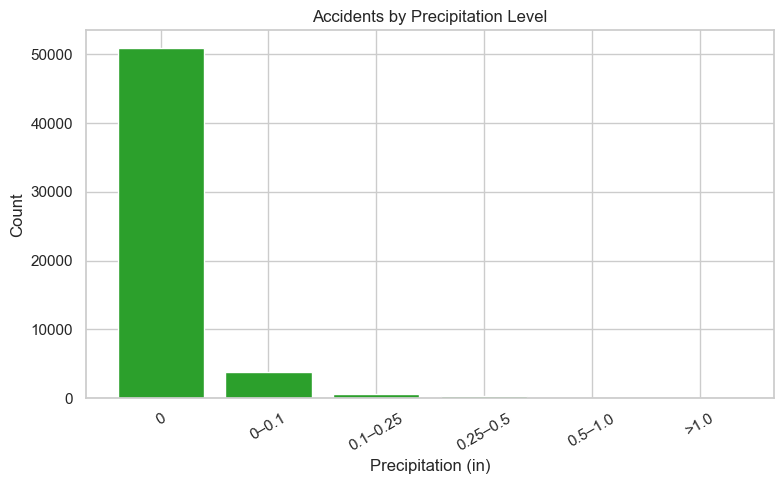

In [19]:
# 3d  Precipitation vs accident count (binned)
fig, ax = plt.subplots(figsize=(8, 5))
precip = austin_df["Precipitation(in)"].dropna()
bins = [-0.001, 0, 0.1, 0.25, 0.5, 1.0, precip.max()+0.1]
labels = ["0","0–0.1","0.1–0.25","0.25–0.5","0.5–1.0",">1.0"]
austin_df["Precip_Bin"] = pd.cut(austin_df["Precipitation(in)"], bins=bins, labels=labels)
p_cnt = austin_df["Precip_Bin"].value_counts().reindex(labels)
ax.bar(labels, p_cnt.values, color="#2ca02c")
ax.set_title("Accidents by Precipitation Level")
ax.set_xlabel("Precipitation (in)")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
# plt.savefig("3d_accidents_by_precipitation.png", dpi=150, bbox_inches="tight")
# print("Saved: 3d_accidents_by_precipitation.png")
plt.show()

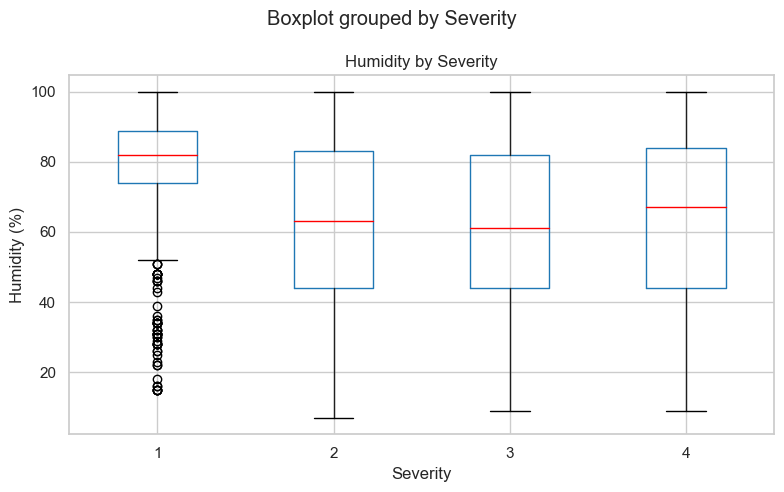

In [20]:
# 3e  Humidity distribution by severity
fig, ax = plt.subplots(figsize=(8, 5))
austin_df.boxplot(column="Humidity(%)", by="Severity", ax=ax,
           boxprops=dict(color="#1f77b4"), medianprops=dict(color="red"))
plt.sca(ax); plt.title("Humidity by Severity")
ax.set_xlabel("Severity")
ax.set_ylabel("Humidity (%)")
plt.tight_layout()
# plt.savefig("3e_humidity_by_severity.png", dpi=150, bbox_inches="tight")
# print("Saved: 3e_humidity_by_severity.png")
plt.show()

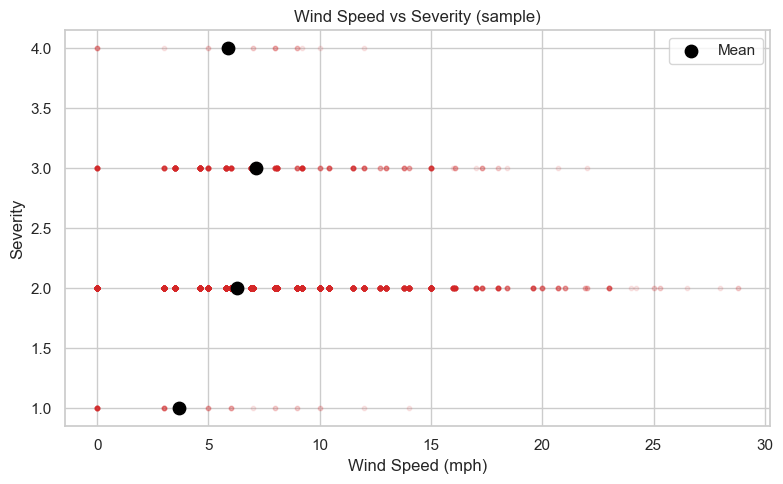

In [21]:
# 3f  Wind speed vs severity scatter (sampled)
fig, ax = plt.subplots(figsize=(8, 5))
sample = austin_df[["Wind_Speed(mph)","Severity"]].dropna().sample(
    min(5000, len(austin_df)), random_state=42)
ax.scatter(sample["Wind_Speed(mph)"], sample["Severity"],
           alpha=0.1, s=10, color="#d62728")
means = sample.groupby("Severity")["Wind_Speed(mph)"].mean()
ax.scatter(means.values, means.index, color="black", s=80, zorder=5, label="Mean")
ax.set_title("Wind Speed vs Severity (sample)")
ax.set_xlabel("Wind Speed (mph)")
ax.set_ylabel("Severity")
ax.legend()
plt.tight_layout()
# plt.savefig("3f_wind_speed_vs_severity.png", dpi=150, bbox_inches="tight")
# print("Saved: 3f_wind_speed_vs_severity.png")
plt.show()

# Accident Hotspots

In [22]:
import folium
from folium.plugins import HeatMap

In [23]:
center_lat = austin_df["Start_Lat"].median()
center_lng = austin_df["Start_Lng"].median()

# ── Full heatmap ──────────────────────────────────────────────────────────
m = folium.Map(location=[center_lat, center_lng], zoom_start=11,
               tiles="CartoDB positron")
heat_data = austin_df[["Start_Lat","Start_Lng"]].dropna().values.tolist()
HeatMap(heat_data, radius=8, blur=12, max_zoom=14,
        gradient={0.2:"blue",0.5:"lime",0.8:"orange",1.0:"red"}).add_to(m)
folium.LayerControl().add_to(m)
m.save("austin_hotspot_heatmap.html")
print("Saved: austin_hotspot_heatmap.html  (open in any browser)")

# ── Severe-only map (severity >= 3) ───────────────────────────────────────
severe = austin_df[austin_df["Severity"] >= 3].copy()
m2 = folium.Map(location=[center_lat, center_lng], zoom_start=11,
                tiles="CartoDB dark_matter")
HeatMap(severe[["Start_Lat","Start_Lng"]].dropna().values.tolist(),
        radius=10, blur=14, max_zoom=14,
        gradient={0.2:"blue",0.5:"yellow",1.0:"red"}).add_to(m2)
m2.save("austin_hotspot_severe_heatmap.html")
print("Saved: austin_hotspot_severe_heatmap.html  (severity ≥ 3 only)")

# ── Top-10 worst streets ──────────────────────────────────────────────────
if "Street" in austin_df.columns:
    top_streets = (austin_df.groupby("Street")
                     .agg(count=("ID","count"), mean_sev=("Severity","mean"))
                     .sort_values("count", ascending=False)
                     .head(10))
    print("\nTop 10 Streets by Accident Count:")
    print(top_streets.to_string())

Saved: austin_hotspot_heatmap.html  (open in any browser)
Saved: austin_hotspot_severe_heatmap.html  (severity ≥ 3 only)

Top 10 Streets by Accident Count:
                 count  mean_sev
Street                          
I-35 S            3332  2.486495
I-35 N            3052  2.507864
N Interstate 35   2178  2.595960
N Lamar Blvd      1654  2.000000
US-183 S          1409  2.129170
Mopac Expy N      1264  2.019778
S Interstate 35   1172  2.616041
W Parmer Ln       1113  2.146451
Mopac Expy S      1023  2.018573
Airport Blvd      1016  2.133858
